In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import pandas as pd
import random
from PIL import Image
import PIL.ImageOps
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm, tqdm_notebook

## Helper functions
Set of helper functions

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [3]:
class Config():
    training_dir = "./data/faceid/train/"
    testing_dir = "./data/faceid/val/"
    train_batch_size = 16
    train_number_epochs = 30
    model_save_path = "./checkpoint/faceID"
    use_cuda = True

In [4]:
class RGBDDataset(Dataset):
    
    def __init__(self, imageFolderDataset, pre_transform=None, transform=None):
        """Note: This needs to be initialized with a minimal set of transformation:
            1. torch.resize
            2. torch.toTensor
        """
        self.imageFolderDataset = imageFolderDataset
        self.pre_transform = pre_transform # Transforms before merging
        self.transform = transform
        
    def __getitem__(self, index):
        """Generates a random sample from the dataset folder"""
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            img1_tuple = random.choice(self.imageFolderDataset.imgs)

        # Get RGBD image (normalised) from disk
        img0 = self.get_RGBD(img0_tuple[0])
        img1 = self.get_RGBD(img1_tuple[0])
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)
    
    @staticmethod
    def read_depthfile(path):
        """Parses and normalises .dat depth files in Kinect Face Database"""
        x = pd.read_csv(path, sep='\t').values
        #x = x[140:340, 220:420] # Center crop
        x[x<0] = 1700 # Median distance
        x[x==0] = 400 # Nearest distance
        x[x>3000] = 3000 # Furthest distance
        x = (x - 400.)/2600 * 255
        x = Image.fromarray(x)
        x = x.convert('L')
        return x
    
    def get_RGBD(self, path):
        """Returns a rgbd data. Assumes .dat data is named *_d.dat"""
        rgb = Image.open(path)
        rgb = rgb.convert("RGB")
        d = self.read_depthfile(path[:-5] + 'd.dat')
        
        # We require a pre-transform here in order to make the rgb and d uniform in size
        # This allows concat before performing random transformations (such as rotation)
        if self.pre_transform is not None:
            rgb = self.pre_transform(rgb)
            d = self.pre_transform(d)
            
        # Merging step
        rgbd = Image.merge(mode='RGBA', bands=rgb.split() + (d,))
        
        if self.transform is not None:
            rgbd = self.transform(rgbd)
            #rgb = self.transform(rgb)
            #d = self.transform(d)
            
        return rgbd
    

## Image Folder Dataset API

In [5]:
dataset = dset.ImageFolder(root=Config.training_dir)

In [6]:
rgbd_dataset = RGBDDataset(imageFolderDataset=dataset,
                          transform=transforms.Compose([transforms.RandomRotation(10),
                                                        transforms.CenterCrop(224),
                                                        transforms.ToTensor()]),
                          pre_transform=transforms.Resize((640,480)))

## Data visualization

In [7]:
vis_dataloader = DataLoader(rgbd_dataset,
                           shuffle=True,
                           num_workers=8,
                           batch_size=8)
dataiter = iter(vis_dataloader)

sample_batch = next(dataiter)

In [8]:
print(sample_batch[0].shape)
print(sample_batch[1].shape)
print(sample_batch[2])

torch.Size([8, 4, 224, 224])
torch.Size([8, 4, 224, 224])

    0
    0
    0
    0
    0
    0
    1
    1
[torch.FloatTensor of size 8x1]



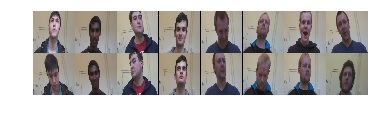

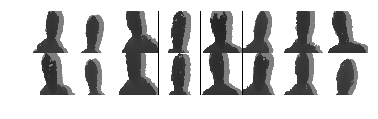

In [9]:
concatenated = torch.cat((sample_batch[0][:,:3:,:,:],sample_batch[1][:,:3:,:,:]),0)
imshow(torchvision.utils.make_grid(concatenated))
concatenated = torch.cat((sample_batch[0][:,3:,:,:],sample_batch[1][:,3:,:,:]),0)
imshow(torchvision.utils.make_grid(concatenated))

## Neural Net Definition
We will use a standard convolutional neural network

In [10]:
class Fire(nn.Module):
    """Fire module from Squeezenet with skip connections"""
    def __init__(self, in_channels, squeeze_channels, expand_channels, batch_norm=True):
        super(Fire, self).__init__()
        self.squeeze_conv = nn.Conv2d(in_channels=in_channels, out_channels=squeeze_channels,
                                     kernel_size=1)
        self.squeeze_conv1 = nn.Conv2d(in_channels=squeeze_channels, out_channels=squeeze_channels,
                                     kernel_size=1)
        self.squeeze_conv2 =nn.Conv2d(in_channels=squeeze_channels, out_channels=expand_channels,
                                     kernel_size=3, padding=1)
        self.batch_norm = batch_norm
        if self.batch_norm:
            self.bn = nn.BatchNorm2d(squeeze_channels+expand_channels)
        
    def forward(self, inp):
        x = F.relu(self.squeeze_conv(inp))
        x1 = F.relu(self.squeeze_conv1(x))
        x2 = F.relu(self.squeeze_conv2(x))
        out = torch.cat((x1,x2), 1)
        
        if self.batch_norm:
            out = self.bn(out)
        return out

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.conv_01 = nn.Conv2d(in_channels=4, out_channels=32, stride=2, kernel_size=5)
        self.bn_01 = nn.BatchNorm2d(32)
        self.fire_grp_01 = nn.Sequential(Fire(32, 16, 16),
                                        Fire(32, 16, 16),
                                        nn.MaxPool2d(2),
                                        nn.Dropout(p=0.1))
        self.fire_grp_02 = nn.Sequential(Fire(32, 32, 32),
                                        Fire(64, 32, 32),
                                        nn.MaxPool2d(2),
                                        nn.Dropout(p=0.2))
        self.fire_grp_03 = nn.Sequential(Fire(64, 32, 64),
                                        Fire(96, 32, 96),
                                        Fire(128, 64, 128),
                                        Fire(192, 64, 192),
                                        nn.MaxPool2d(2),
                                        nn.Dropout(p=0.3))
        
        self.fc1 = nn.Sequential(
            nn.Linear(256*6*6, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.4),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True))

    def forward_once(self, x):
        x = self.conv_01(x)
        x = self.bn_01(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.fire_grp_01(x)
        x = self.fire_grp_02(x)
        x = self.fire_grp_03(x)
        x = x.view(x.size()[0], -1)
        x = self.fc1(x)
        x = F.normalize(x)
        return x #output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [11]:
test_mod = SiameseNetwork()
inp = Variable(torch.zeros(7,4,224,224))
out = test_mod.forward_once(inp)
print("Number of trainable parameters: ", count_parameters(test_mod))
print(out.shape)

Number of trainable parameters:  5086880
torch.Size([7, 128])


## Contrastive Loss

In [12]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training

In [13]:
train_dataloader = DataLoader(rgbd_dataset,
                        shuffle=False,
                        num_workers=16,
                        batch_size=Config.train_batch_size)

In [14]:
net = SiameseNetwork()
if Config.use_cuda:
    net = net.cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [15]:
counter = []
loss_history = [] 
iteration_number= 0

Loss: 0.121937: 100%|██████████| 83/83 [01:18<00:00,  1.06it/s]


Saving model


Loss: 0.109244: 100%|██████████| 83/83 [01:11<00:00,  1.16it/s]

Saving model



Loss: 0.047751: 100%|██████████| 83/83 [01:10<00:00,  1.18it/s]


Saving model


Loss: 0.130396: 100%|██████████| 83/83 [01:16<00:00,  1.09it/s]


Saving model


Loss: 0.051798: 100%|██████████| 83/83 [01:17<00:00,  1.07it/s]


Saving model


Loss: 0.013316: 100%|██████████| 83/83 [01:14<00:00,  1.12it/s]


Saving model


Loss: 0.031827: 100%|██████████| 83/83 [01:12<00:00,  1.14it/s]


Saving model


Loss: 0.072381: 100%|██████████| 83/83 [01:11<00:00,  1.15it/s]


Saving model


Loss: 0.011466: 100%|██████████| 83/83 [01:12<00:00,  1.15it/s]


Saving model


Loss: 0.050509: 100%|██████████| 83/83 [01:11<00:00,  1.15it/s]


Saving model


Loss: 0.042566: 100%|██████████| 83/83 [01:12<00:00,  1.15it/s]


Saving model


Loss: 0.026725: 100%|██████████| 83/83 [01:12<00:00,  1.14it/s]


Saving model


Loss: 0.013220: 100%|██████████| 83/83 [01:13<00:00,  1.13it/s]


Saving model


Loss: 0.015570: 100%|██████████| 83/83 [01:13<00:00,  1.13it/s]

Saving model



Loss: 0.012480: 100%|██████████| 83/83 [01:14<00:00,  1.11it/s]


Saving model


Loss: 0.007460: 100%|██████████| 83/83 [01:13<00:00,  1.13it/s]

Saving model



Loss: 0.045140: 100%|██████████| 83/83 [01:13<00:00,  1.13it/s]


Saving model


Loss: 0.008609: 100%|██████████| 83/83 [01:12<00:00,  1.15it/s]


Saving model


Loss: 0.019252: 100%|██████████| 83/83 [01:10<00:00,  1.17it/s]


Saving model


Loss: 0.021175: 100%|██████████| 83/83 [01:11<00:00,  1.17it/s]

Saving model



Loss: 0.020562: 100%|██████████| 83/83 [01:09<00:00,  1.20it/s]


Saving model


Loss: 0.012618: 100%|██████████| 83/83 [01:09<00:00,  1.20it/s]

Saving model



Loss: 0.022112: 100%|██████████| 83/83 [01:08<00:00,  1.21it/s]


Saving model


Loss: 0.015415: 100%|██████████| 83/83 [01:09<00:00,  1.20it/s]

Saving model



Loss: 0.007589: 100%|██████████| 83/83 [01:09<00:00,  1.20it/s]

Saving model



Loss: 0.022578: 100%|██████████| 83/83 [01:08<00:00,  1.21it/s]

Saving model



Loss: 0.037993: 100%|██████████| 83/83 [01:09<00:00,  1.20it/s]


Saving model


Loss: 0.010127: 100%|██████████| 83/83 [01:08<00:00,  1.22it/s]


Saving model


Loss: 0.005464: 100%|██████████| 83/83 [01:08<00:00,  1.21it/s]


Saving model


Loss: 0.003431: 100%|██████████| 83/83 [01:08<00:00,  1.22it/s]


Saving model


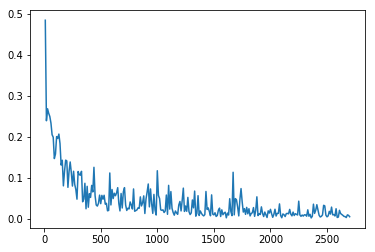

In [16]:
for epoch in range(0,Config.train_number_epochs):
    data_iter = tqdm(enumerate(train_dataloader,0), total=len(train_dataloader))
    for i, data in data_iter:
        img0, img1, label = data
        if Config.use_cuda:
            img0, img1, label = Variable(img0).cuda(), Variable(img1).cuda() , Variable(label).cuda()
        output1, output2 = net(img0, img1)
        optimizer.zero_grad()
        loss_contrastive = criterion(output1, output2, label)
        loss_contrastive.backward()
        optimizer.step()
        data_iter.set_description("Loss: %.6f" % float(loss_contrastive))
        if i %10 == 0 :
            #print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.data[0]))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.data[0])
    #Save model
    print("Saving model")
    torch.save(net.state_dict(), Config.model_save_path)
show_plot(counter,loss_history)

## Some simple testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

In [29]:
net.load_state_dict(torch.load(Config.model_save_path))

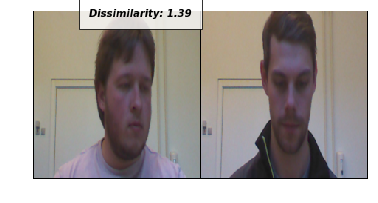

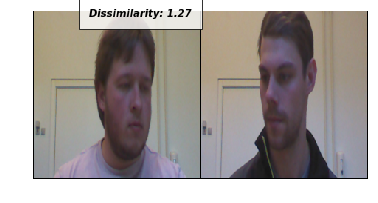

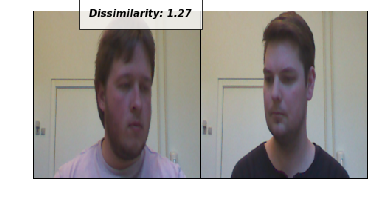

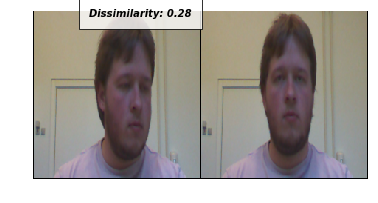

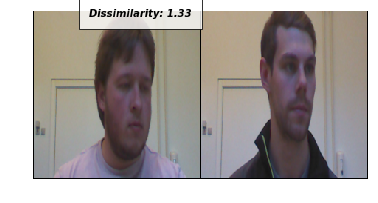

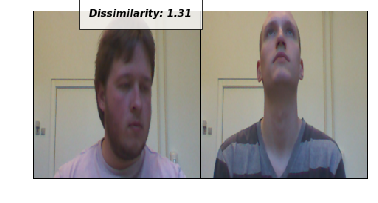

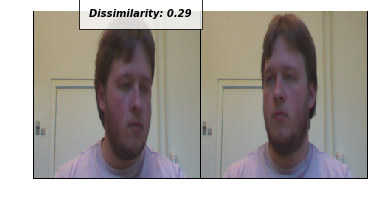

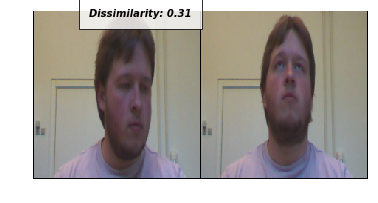

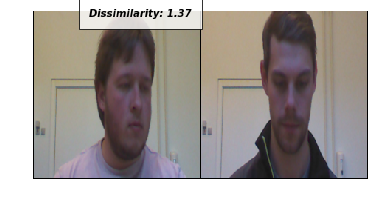

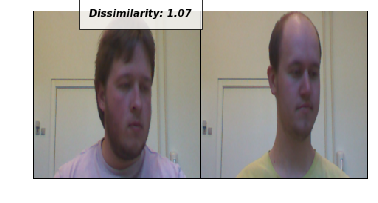

In [28]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
rgbd_test_dataset = RGBDDataset(imageFolderDataset=folder_dataset_test,
                                transform=transforms.Compose([transforms.CenterCrop(224),
                                                        transforms.ToTensor()]),
                          pre_transform=transforms.Resize((640,480)))

test_dataloader = DataLoader(rgbd_test_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0[:,:3,:,:],x1[:,:3,:,:]),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.cpu().data.numpy()[0][0]))



In [21]:
x0.shape

torch.Size([1, 4, 224, 224])